In [184]:
import pandas as pd
from configurator import Config
from pathlib import Path
from matplotlib.pyplot import gca, subplot, figure
from matplotlib.gridspec import GridSpec
from matplotlib.dates import DateFormatter
from operator import itemgetter

In [4]:
config = Config.from_path('config.yaml')
root = Path(config.directories.storage).expanduser()

In [33]:
date = '2023-12-01'
zappi_data = pd.read_csv(root / pd.Timestamp(date).strftime('zappi-%Y-%m-%d.csv'), index_col='datetime', parse_dates=[0]).loc[:date+' 06:00']
octopus_data = pd.read_csv(root / pd.Timestamp(date).strftime('octopus-%Y-%m-%d.csv'), index_col='interval_end', parse_dates=[0,1]).loc[:date+' 06:00']

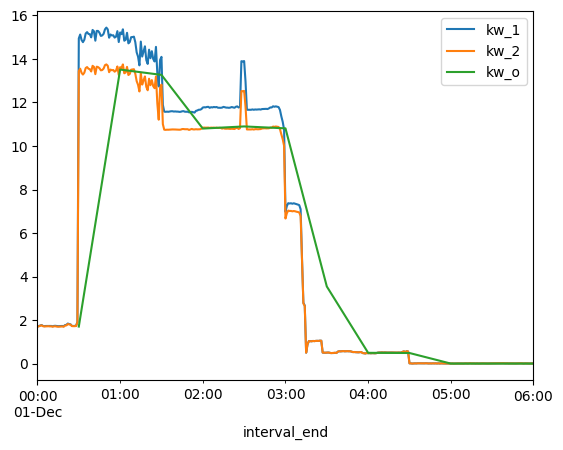

In [34]:
volts = zappi_data['v1'] / 10
joules = zappi_data['imp']
kw_1 = (joules / volts * 4) / 1000
kw_2 = (joules / 60) / 1000

kw_o = octopus_data['consumption'] *2

ax = gca()
kw_1.plot(ax=ax, label='kw_1')
kw_2.plot(ax=ax, label='kw_2')
kw_o.plot(ax=ax, label='kw_o')
ax.legend()

In [21]:
zappi_sorted = []
for path in sorted(Path('data').glob('zappi-*.csv')):
    data = pd.read_csv(path, index_col='datetime', parse_dates=[0])
    if data.empty:
        continue
    max_series = data['imp_kw'].rolling(20).mean()+data['h1b_kw'].rolling(20).mean()   
    idxmax = max_series.idxmax()
    if idxmax is pd.NaT:
        continue
    zappi_sorted.append((max_series.max(), max_series.idxmax()))
zappi_sorted.sort(reverse=True)

/var/folders/m6/tsd59qsj7pd_lldh4mhwh6kh0000gn/T/ipykernel_48167/672737222.py:7: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  idxmax = max_series.idxmax()
/var/folders/m6/tsd59qsj7pd_lldh4mhwh6kh0000gn/T/ipykernel_48167/672737222.py:7: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  idxmax = max_series.idxmax()
/var/folders/m6/tsd59qsj7pd_lldh4mhwh6kh0000gn/T/ipykernel_48167/672737222.py:7: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  idxmax = max_series.idxmax()


In [97]:
def lines(ax):
    ax.axhline(y=240 * 65 / 1000, color='grey', linestyle='dashed', label='65A')
    ax.axhline(y=7.5, color='grey', linestyle='dotted', label='7.5kW')

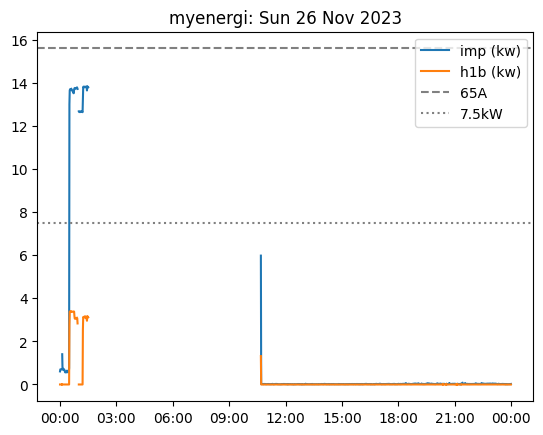

In [210]:
def plot_zappi_date(date, ax=None):
    ax = ax or gca()
    ax.set_title(date.strftime('myenergi: %a %d %b %Y'))
    path = root / date.strftime('zappi-%Y-%m-%d.csv')
    if path.exists():
        zappi_data = pd.read_csv(path, index_col='datetime', parse_dates=[0])
        zappi_data = zappi_data.reindex(
            index=pd.date_range(
                start=zappi_data.index.min(),
                end=zappi_data.index.max(),
                freq='1 min'
            ),
        )
        ax.plot(zappi_data['imp_kw'], label='imp (kw)')
        ax.plot(zappi_data['h1b_kw'], label='h1b (kw)')
    lines(ax)
    ax.legend()
    ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))

plot_zappi_date(pd.Timestamp('2023-11-26'))

In [99]:
tesla_sorted = []
for path in sorted(Path('data').glob('tesla-*.csv')):
    data = pd.read_csv(path, index_col='timestamp', parse_dates=[0])
    tesla_sorted.append((data['grid_power'].max(), data['grid_power'].idxmax()))
tesla_sorted.sort(reverse=True)

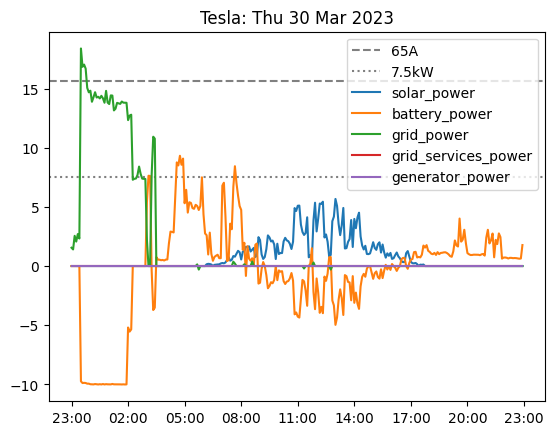

In [189]:
def plot_tesla_date(date, ax=None, abs=True):
    date = pd.Timestamp(date)
    tesla_data = pd.read_csv(root / date.strftime('tesla-%Y-%m-%d.csv'), index_col='timestamp', parse_dates=[0])
    ax = ax or gca()
    ax.set_title(date.strftime('Tesla: %a %d %b %Y'))
    lines(ax)
    ax.legend()
    tesla_kw = (tesla_data / 1000)
    if abs:
        tesla_kw = tesla_kw.abs().rename(columns=lambda name: f'abs({name})')
    for col in tesla_kw:
        ax.plot(tesla_kw[col], label=col)
    ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
    ax.legend()

plot_tesla_date(pd.Timestamp('2023-03-30'), abs=False)

In [29]:
for max_kw, max_dt in zappi_sorted[:20]:
    print(f'{max_dt:%Y-%m-%d}: {max_kw:.3f}')

2021-08-03: 22.719
2021-08-02: 22.717
2021-07-26: 22.698
2021-11-26: 22.691
2021-07-27: 22.687
2021-10-31: 22.675
2021-09-03: 22.669
2021-12-29: 22.668
2022-01-24: 22.667
2022-03-20: 22.664
2021-10-23: 22.654
2021-10-22: 22.644
2021-11-20: 22.637
2021-10-14: 22.630
2021-12-22: 22.627
2021-12-10: 22.627
2020-12-18: 22.620
2021-10-01: 22.592
2021-10-29: 22.582
2021-10-09: 22.576


In [34]:
for max_kw, max_dt in tesla_sorted[:20]:
    print(f'{max_dt:%Y-%m-%d}: {max_kw:.3f}')

2023-12-25: 20191.500
2021-01-11: 18521.800
2023-03-30: 18388.167
2023-04-11: 17874.857
2022-12-31: 17641.333
2021-11-17: 17557.000
2022-03-26: 17214.429
2021-12-25: 16967.600
2022-12-24: 16931.431
2023-09-10: 16648.000
2023-03-29: 16508.143
2023-09-30: 16473.429
2022-12-25: 16443.167
2023-10-15: 16439.500
2023-12-26: 16188.857
2023-03-18: 16161.667
2023-01-01: 16143.167
2023-07-31: 16096.833
2023-08-02: 16016.333
2023-10-04: 15974.143


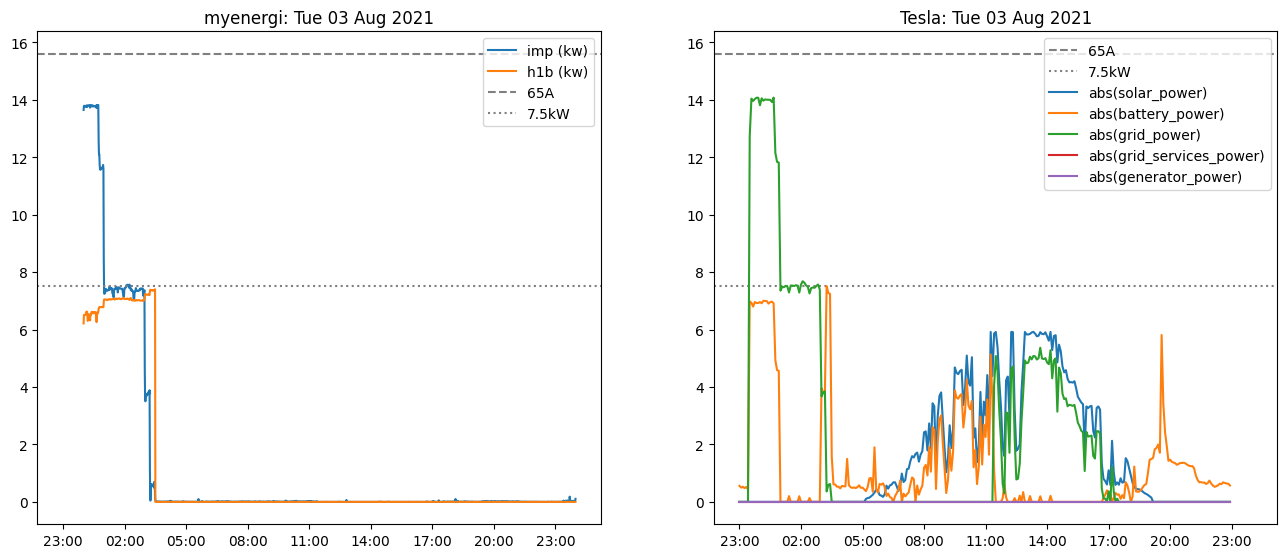

In [211]:
def make_gs(rows: int):
    fig = figure(figsize=(16, rows*32/5), dpi=100)
    fig.set_facecolor('white')
    gs = GridSpec(rows, 2)
    gs.update(hspace=0.3)
    return gs

def plot_date(dt, gs=None, i=0, *, tesla_day_offset=0, tesla_abs=True):
    if isinstance(dt, str):
        dt = pd.Timestamp(dt)
    if gs is None:
        gs = make_gs(rows=1)
    ax = subplot(gs[i, 0])
    plot_zappi_date(dt, ax)
    ax = subplot(gs[i, 1], sharey=ax, sharex=ax)
    plot_tesla_date(dt + pd.Timedelta(days=tesla_day_offset), ax, abs=tesla_abs)

plot_date('2021-08-03', tesla_day_offset=0)

In [212]:
def plot_from(sorted, *, count=None):
    gs = make_gs(len(sorted) if count is None else count)
    for i, (max_kw, max_dt) in enumerate(sorted if count is None else sorted[:count]):
        plot_date(max_dt, gs, i)

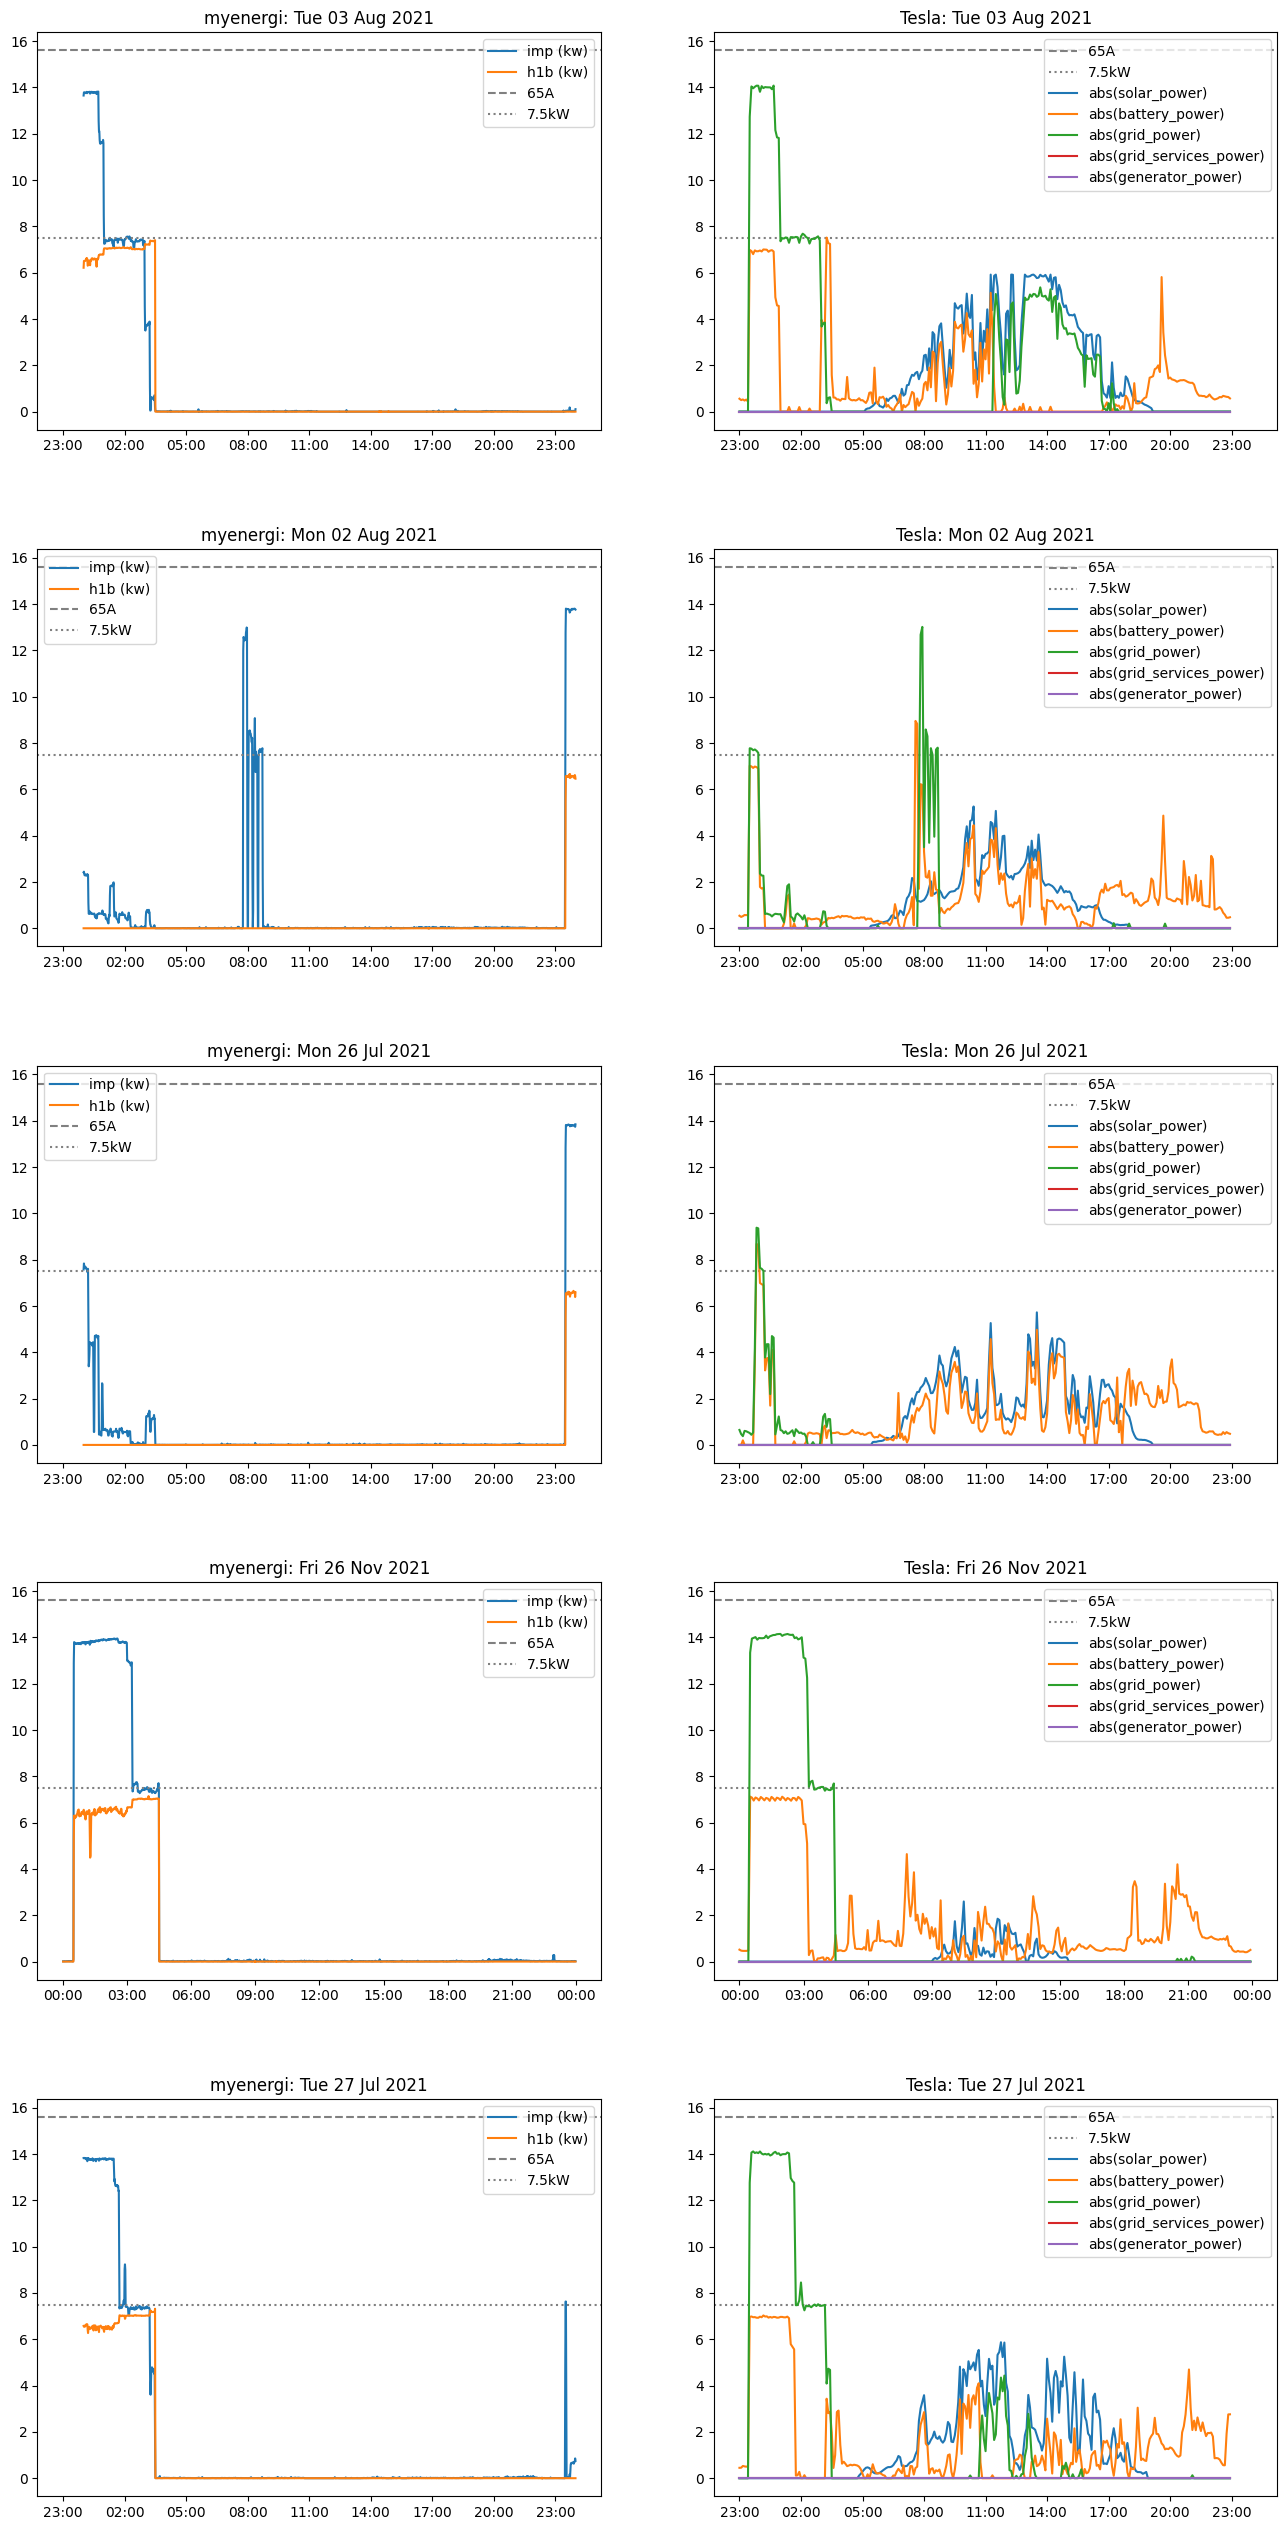

In [213]:
plot_from(zappi_sorted, count = 5)

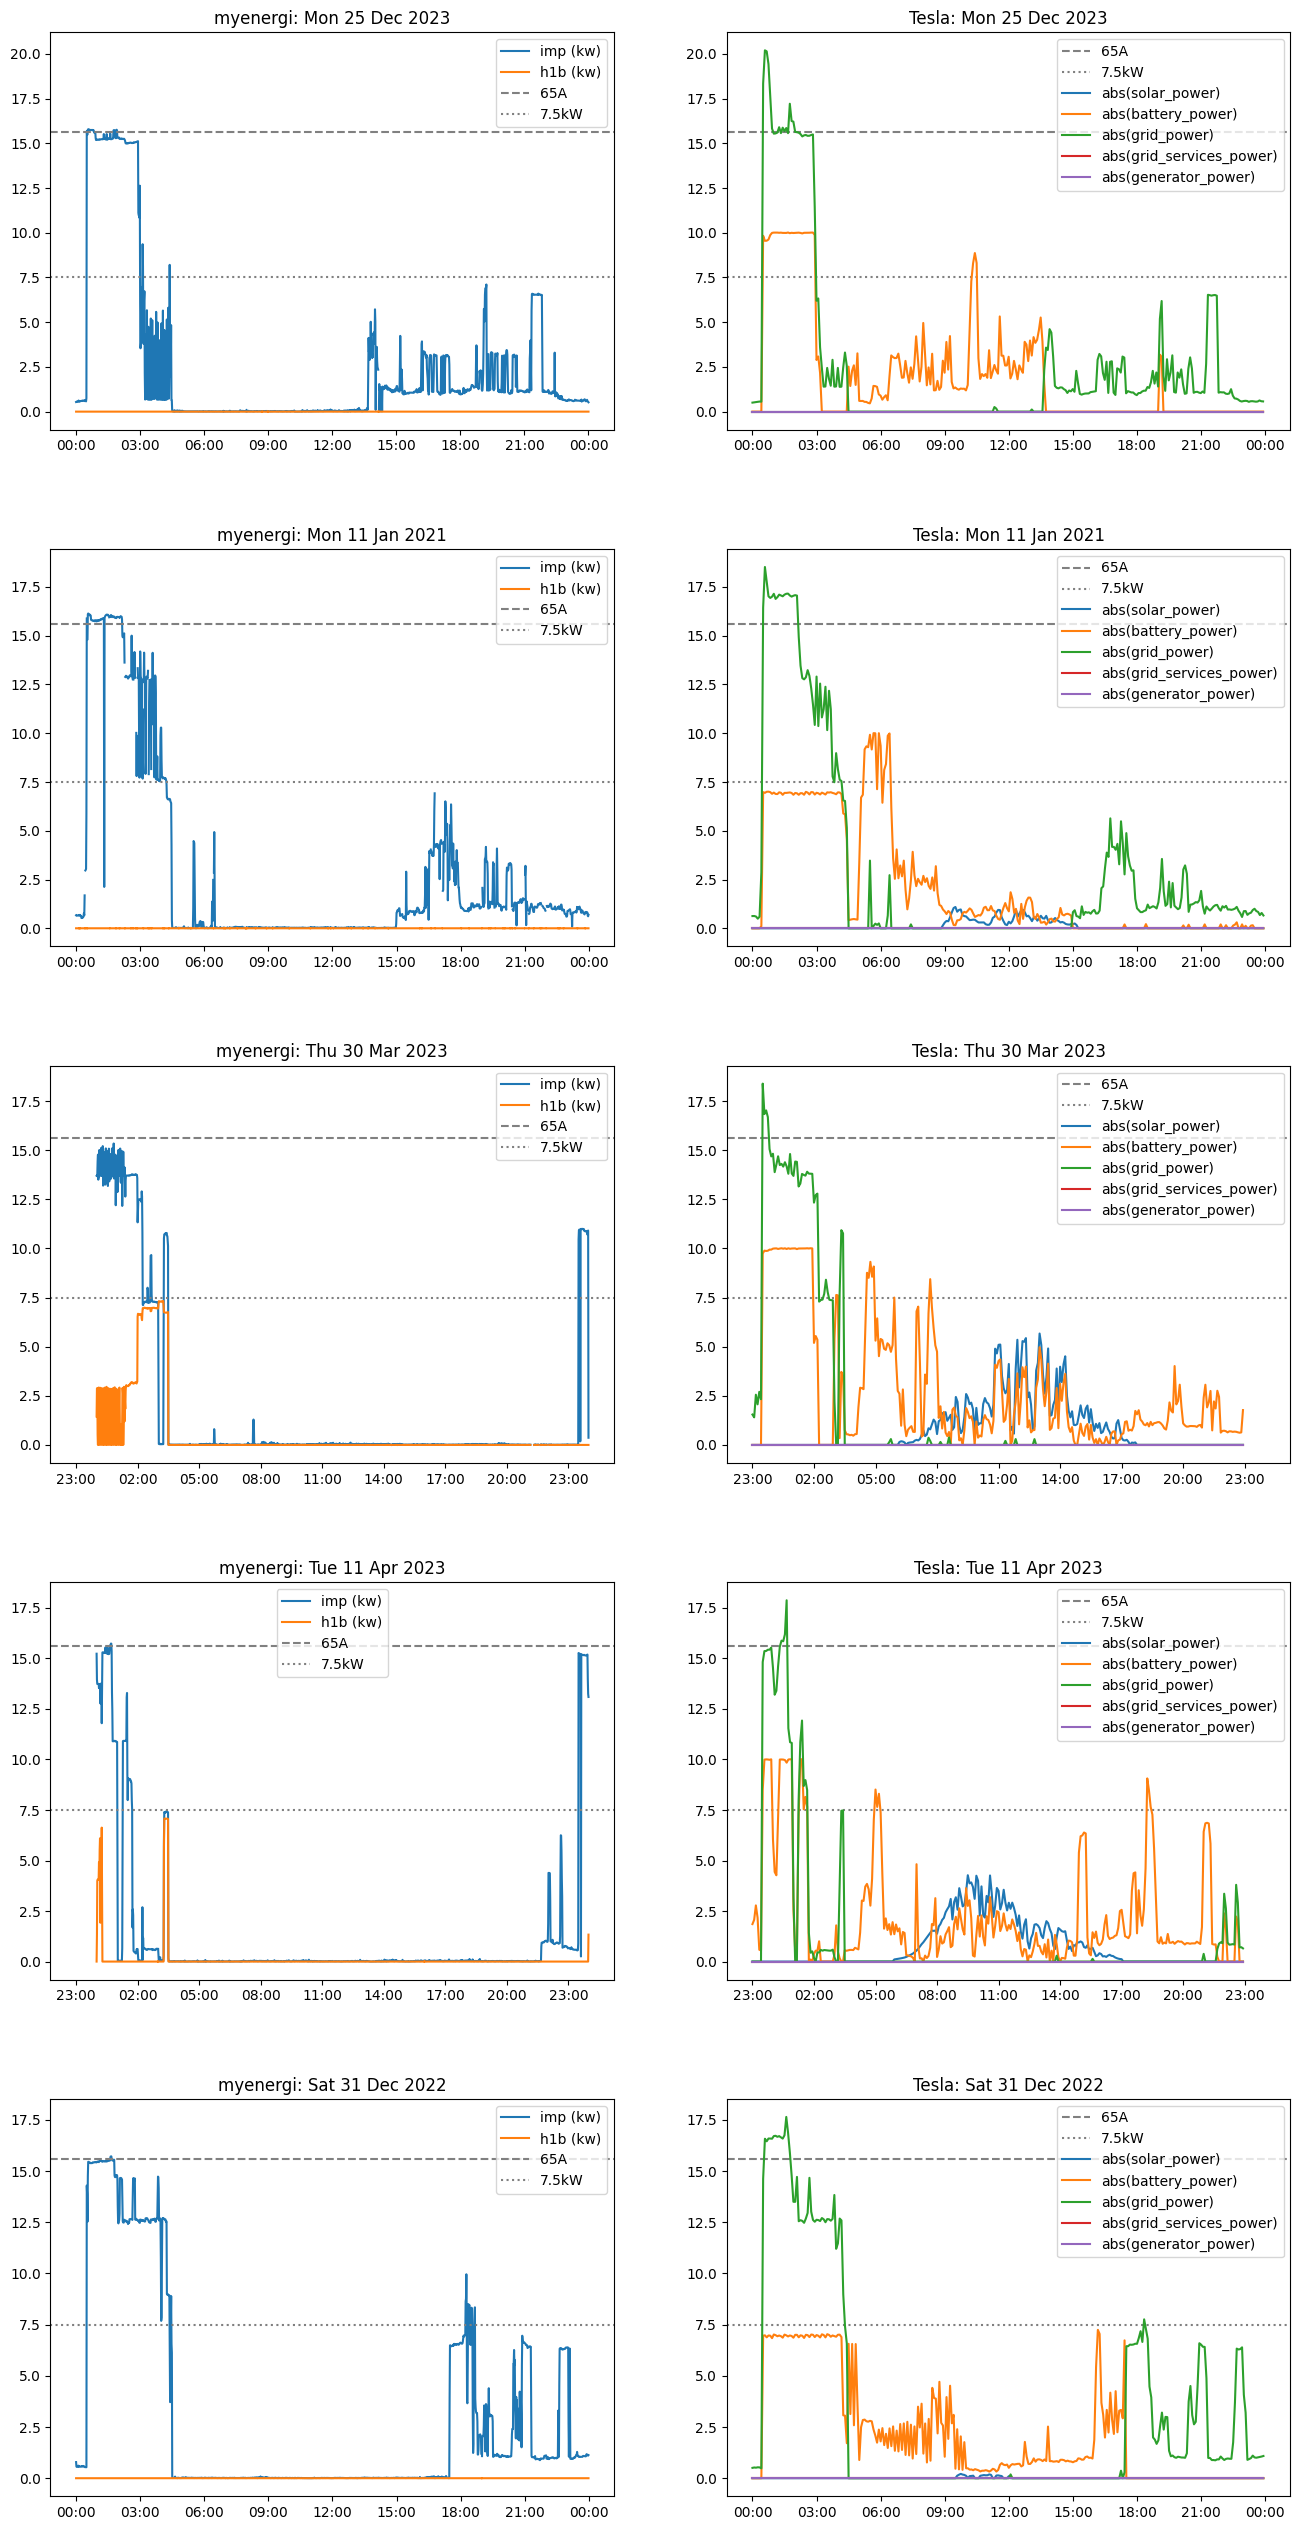

In [214]:
plot_from(tesla_sorted, count = 5)

In [148]:
zappi_biggest_charges = []
for path in sorted(Path('data').glob('zappi-*.csv')):
    data = pd.read_csv(path, index_col='datetime', parse_dates=[0])
    if data.empty:
        continue
    zappi_biggest_charges.append((data['h1b'].sum(), data['h1b'].idxmax()))
zappi_biggest_charges.sort(reverse=True)

In [150]:
for joules, max_dt in zappi_biggest_charges[:20]:
    print(f'{max_dt:%Y-%m-%d}: {joules/(60*60*1000):.1f}')

2021-04-17: 48.4
2022-02-09: 32.1
2021-10-02: 31.6
2021-10-31: 30.3
2021-10-25: 27.7
2022-07-17: 27.0
2022-11-02: 26.9
2022-03-20: 26.7
2021-10-30: 26.7
2022-11-21: 26.6
2023-02-21: 26.6
2022-11-03: 26.6
2021-11-26: 26.5
2021-03-31: 26.4
2021-09-04: 26.3
2023-01-14: 26.3
2022-11-16: 26.2
2021-12-10: 26.0
2023-09-03: 25.9
2023-02-28: 25.8


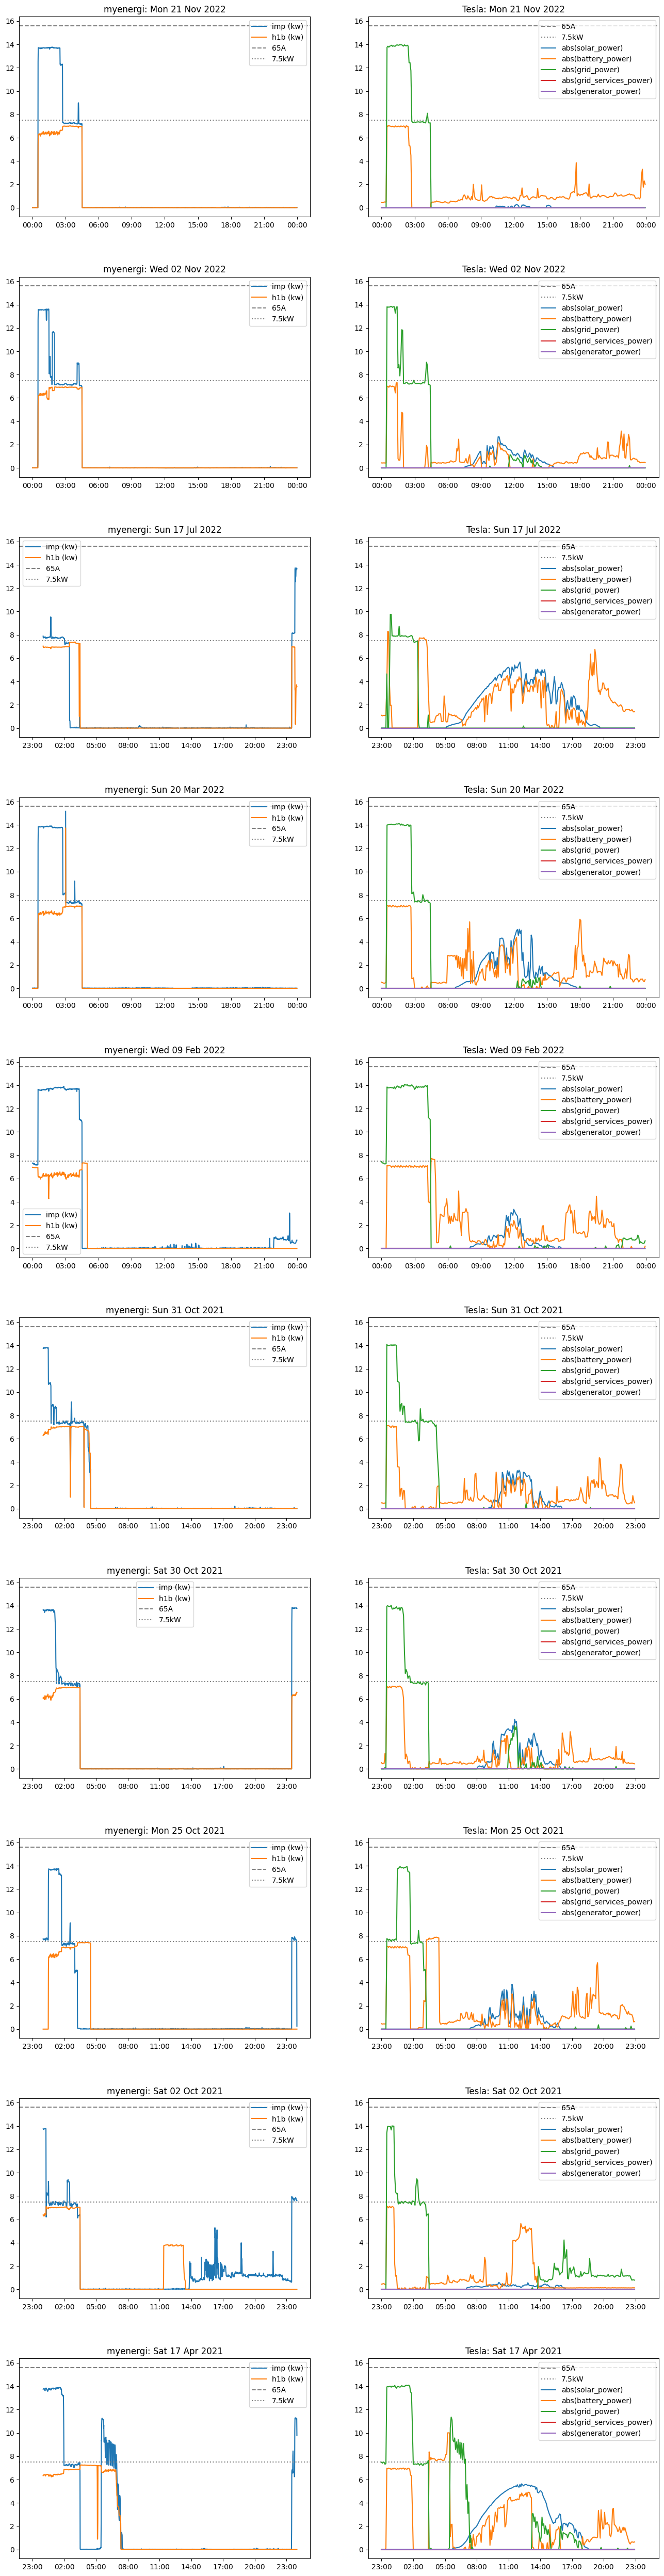

In [215]:
plot_from(sorted(zappi_biggest_charges[:10], key=itemgetter(1), reverse=True))

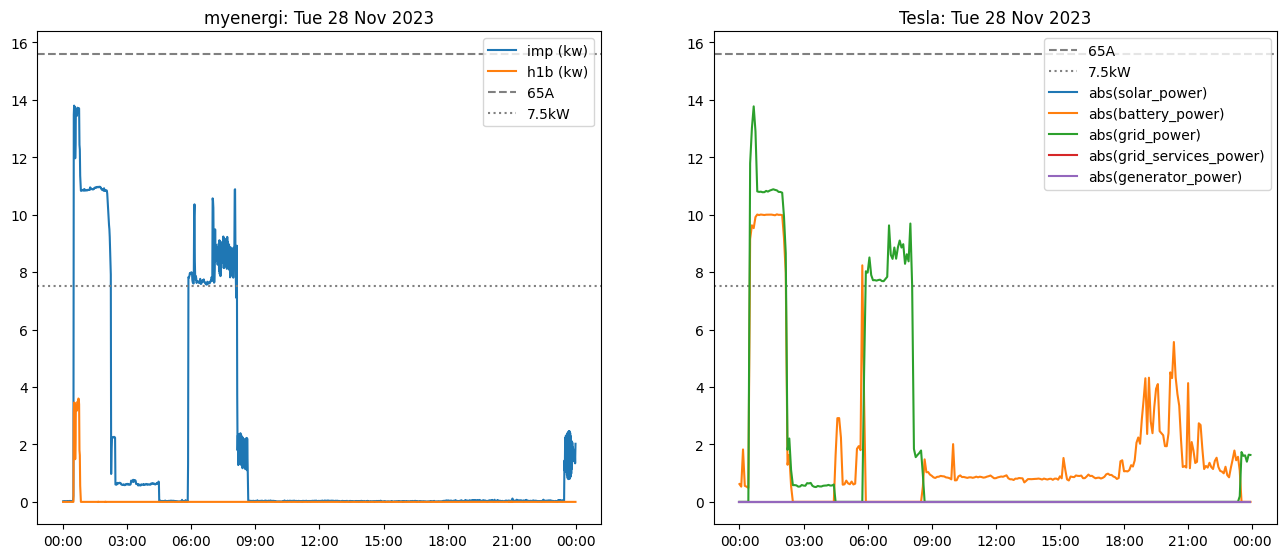

In [225]:
plot_date('2023-11-28')

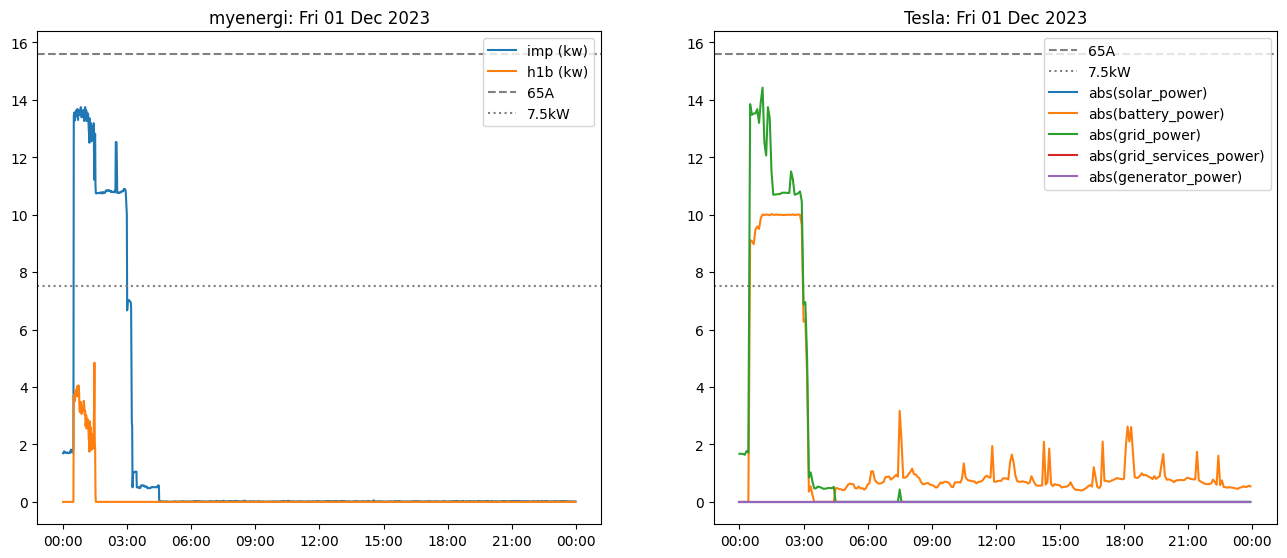

In [228]:
plot_date('2023-12-01')

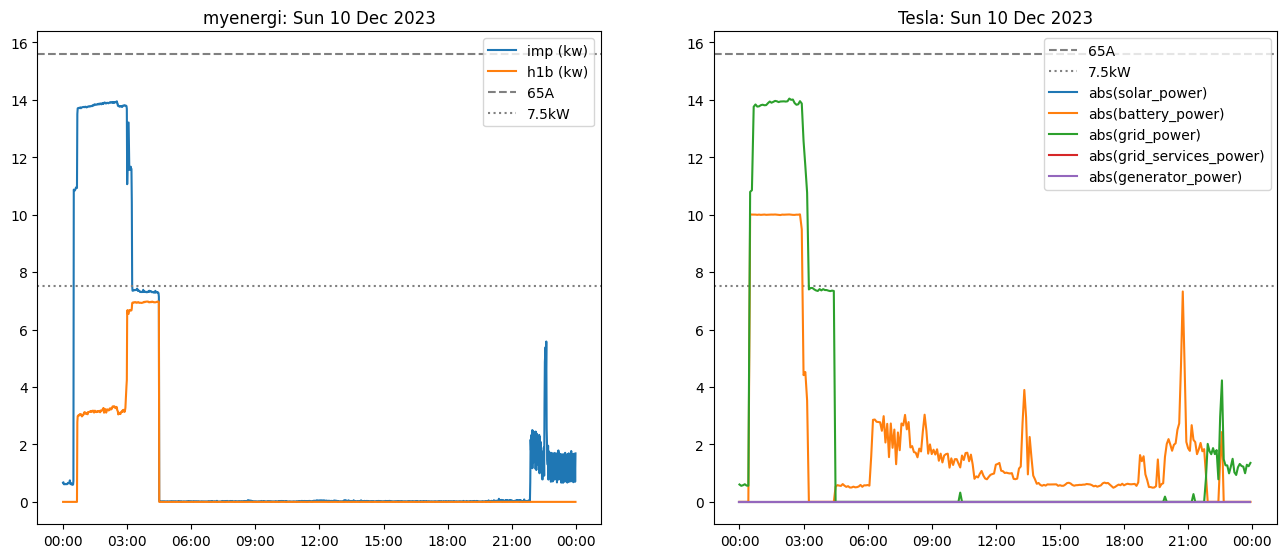

In [231]:
plot_date('2023-12-10')

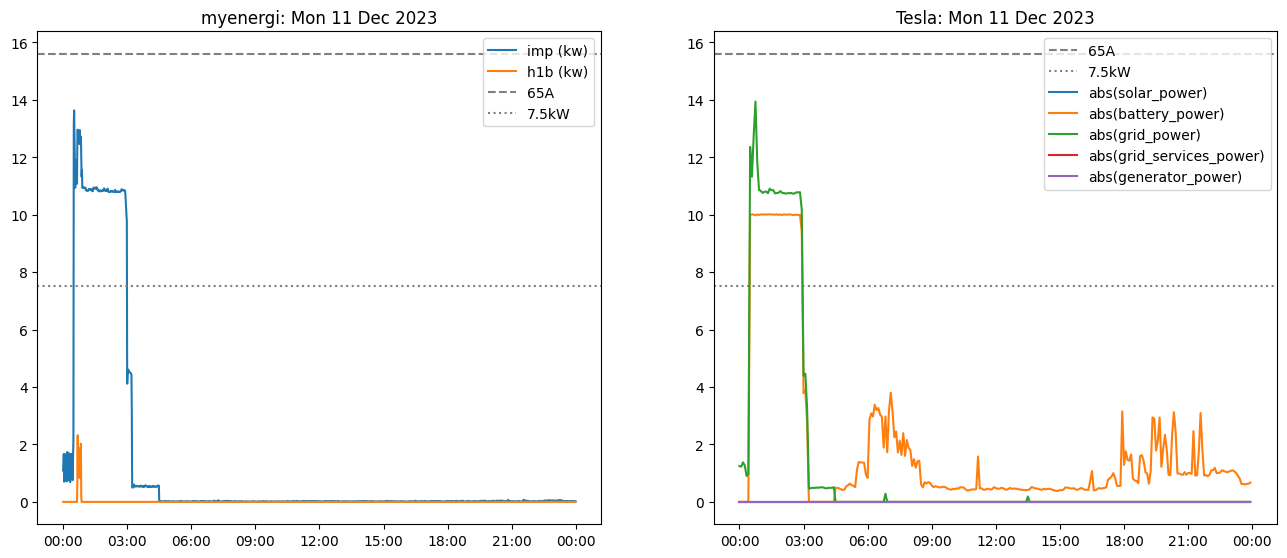

In [232]:
plot_date('2023-12-11')